In [1]:
import re
import sys
import pickle as pkl 
import time

import pandas as pd
import numpy as np
import datetime
from scipy.spatial.distance import cdist

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

Custom functions

In [2]:
from matching import row_corr, row_corr_weighted, match

### Load the NCC Data

In [3]:
ncc = pd.read_csv('../data/NCC_2018_nutrients_per_100g_originalcolnames.txt',sep='\t')

ncc = ncc.rename(columns={'Food ID':'NCC Food ID'})

### Load the data from the ASA24 Recalls

In [4]:
asa_24 = pd.read_csv('../data/training_for_GS_122118.csv')

### Load the file listing matching columns between the datasets

In [5]:
matching = pd.read_csv('../data/matching_ncc_fndds_columns.txt',sep='\t')

Get the list of columns for each dataset

In [6]:
ncc_cols = matching['NCC.Term'].values.tolist()
asa_24_cols = matching['FNDDS.Term'].values.tolist()
asa_24_cols = [val.replace(" ","") for val in asa_24_cols]

### Calculate the pairwise correlations

Get the columns provided by the `matching` file

In [7]:
A = asa_24.loc[:,asa_24_cols].values
B = ncc.loc[:,ncc_cols].values

In [8]:
PCC_unweighted = row_corr(A,B)

/share/lemaylab-backedup/lactoseML/scripts/matching.py:20: RuntimeWarning: divide by zero encountered in true_divide
  pcorr = ((p1 - p2)/np.sqrt(p3*p4[:,None]))
/share/lemaylab-backedup/lactoseML/scripts/matching.py:20: RuntimeWarning: invalid value encountered in true_divide
  pcorr = ((p1 - p2)/np.sqrt(p3*p4[:,None]))


### Calculate weighted pairwise correlations

Load the weights from the Lasso model

In [9]:
lasso_coef = pd.read_csv('lasso_coef.csv')
weights = lasso_coef.loc[:,'coef'].values[:-1] #omit 'year'

Define a function to calculate weighted row-wise PCC

In [10]:
PCC_weighted = row_corr_weighted(A,B,weights)

/share/lemaylab-backedup/lactoseML/scripts/matching.py:31: RuntimeWarning: divide by zero encountered in true_divide
  pcorr = np.matmul(A,((B*w).T))/np.sqrt(np.matmul(((A**2)*w).sum(1)[:,None],(((B**2)*w).sum(1)[:,None]).T))
/share/lemaylab-backedup/lactoseML/scripts/matching.py:31: RuntimeWarning: invalid value encountered in true_divide
  pcorr = np.matmul(A,((B*w).T))/np.sqrt(np.matmul(((A**2)*w).sum(1)[:,None],(((B**2)*w).sum(1)[:,None]).T))


### Calculate similarity between labels

Preprocess the food names, remove delimiting characters and set to lower case

In [11]:
A_labels = asa_24.Food_Description.values

B_labels = ncc['Short Food Description'].values

A_labels = [re.sub('[.\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in A_labels]
B_labels = [re.sub('[.\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in B_labels]

### TF-IDF

Compute the tf-idf vector for each label, then match labels based on cosine similarity. tf-idf stands for Term Frequency-Inverse Document Frequency. In this case it is used to generate a unique numerical vector that is representative of the text content in each label.

N-gram code and inspiration from: https://bergvca.github.io/2017/10/14/super-fast-string-matching.html

Define a function to generate all n-grams from each label, to be used as analyzer in tf-idf vectorizer

In [12]:
def ngrams(string, n=3):
    comma_sep_chunks = [tok.strip() for tok in string.split(',')]
    string = ' '.join([comma_sep_chunks[0]] + comma_sep_chunks)
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams] + comma_sep_chunks

Concatenate the labels from A (ASA24) and B (NCC) datasets

In [13]:
all_labels = A_labels + B_labels

Fit tf-idf vectorizer to the full set of labels, compute tf-idf vectors for A and B

In [14]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
vectorizer.fit(all_labels)
tf_idf_A = vectorizer.transform(A_labels)
tf_idf_B = vectorizer.transform(B_labels)

Compute similarity matrix between A and B labels using cosine similarity

In [15]:
tf_idf_sim = np.array(cosine_similarity(tf_idf_A,tf_idf_B))

### Get results (unweighted)

In [33]:
results_top = {}
results_top_desc_only = {}

Combine the tf-idf similarity and pcc similarity matrices using element-wise multiplication

In [34]:
PCC_TFIDF_unweighted = np.multiply(tf_idf_sim,PCC_unweighted)
PCC_TFIDF_weighted = np.multiply(tf_idf_sim,PCC_weighted)

In [35]:
TOP=5

In [36]:
results_top['PCC_unweighted'] = match(PCC_unweighted,asa_24,ncc,TOP)
results_top['PCC_weighted'] = match(PCC_weighted,asa_24,ncc,TOP)
results_top['PCC_TFIDF_unweighted'] = match(PCC_TFIDF_unweighted,asa_24,ncc,TOP)
results_top['PCC_TFIDF_weighted'] = match(PCC_TFIDF_weighted,asa_24,ncc,TOP)

/software/anaconda3/4.5.12/lssc0-linux/lib/python3.6/site-packages/scipy/stats/stats.py:1025: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


#### Reduce results to description only

In [37]:
desc_only_cols = ['FoodCode','Food_Description','year','lac.per.100g','similarity','NCC Food ID','Keylist','Food Description','Short Food Description','Food Type','Lactose (g)','variation']

In [38]:
for key in results_top.keys():
    results_top_desc_only[key] = results_top[key][desc_only_cols]

### Save results to CSV

In [51]:
for key, df in results_top.items():
    name = key+'_matching_results_top_{}.tsv'.format(TOP)
    path = '../data/' + name
    df.to_csv(path,sep='\t',index=False)

In [52]:
for key, df in results_top_desc_only.items():
    name = key+'_matching_results_top_{}_desc_only.tsv'.format(TOP)
    path = '../data/' + name
    df.to_csv(path,sep='\t',index=False)

### Evaluate results

Get first matches only in a dataframe

In [40]:
# first_matches = results_top.loc[(results_top_desc_only.index.get_level_values('match_index') == 0)]

Add a column indicating the error between matched and labelled lactose

In [41]:
# first_matches['error'] = abs(first_matches['lac.per.100g'] - first_matches['Lactose (g)'])

View the first matches, sorted by error

In [42]:
# first_matches[desc_only_cols + ['error']].sort_values('error',ascending=False)

#### Compute error measures

In [43]:
# # labeled_lactose = results_top.loc[:,'lac.per.100g']
# # labeled_lactose = labeled_lactose[~np.isnan(labeled_lactose)].values()

# labeled_lactose_first = first_matches['lac.per.100g']
# lookup_lactose_first = first_matches['Lactose (g)']
# lookup_lactose_mean_top = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(np.mean)).values.flatten()
# # labeled_lactose_nonzero = labeled_lactose[labeled_lactose != 0]
# # lookup_lactose_nonzero = lookup_lactose[labeled_lactose != 0]

In [44]:
# def mean_absolute_percentage_error_nz(y_true, y_pred): 
#     """Compute mean absolute percentage error (MAPE) between actual and predicted vectors, where actual is nonzero"""
#     y_true_nz = y_true[y_true != 0]
#     y_pred_nz = y_pred[y_true != 0]
#     return np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

In [45]:
# def score(actual,pred):
#     """compute and display MAE, MAPE, R2 between actual and predicted vectors"""
#     print('MAE: {}'.format(round(mean_absolute_error(actual,pred),2)))
#     print('MAPE: {}'.format(round(mean_absolute_percentage_error_nz(actual,pred),2)))
#     print('R2: {}'.format(round(r2_score(actual,pred),2)))

#### Results

First matches

In [457]:
# score(labeled_lactose_first,lookup_lactose_first)

MAE: 0.48
MAPE: 209.51
R2: 0.77


Mean of top 5 matches

In [458]:
# score(labeled_lactose_first,lookup_lactose_mean_top)

MAE: 0.87
MAPE: 298.3
R2: 0.61


#### Actual vs Predicted plots

In [404]:
# def plot_results(actual,pred,title):
#     """actual vs. predicted plot"""
#     plt.scatter(x=actual,y=pred,s=3)
#     plt.xlabel('Dietitian-selected value')
#     plt.ylabel('Matched value')
#     plt.title(title)

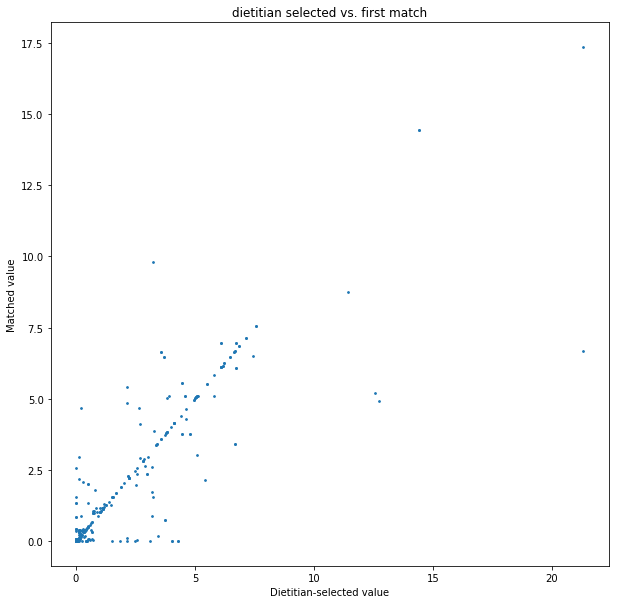

In [405]:
# plot_results(labeled_lactose_first,lookup_lactose_first,'dietitian selected vs. first match')

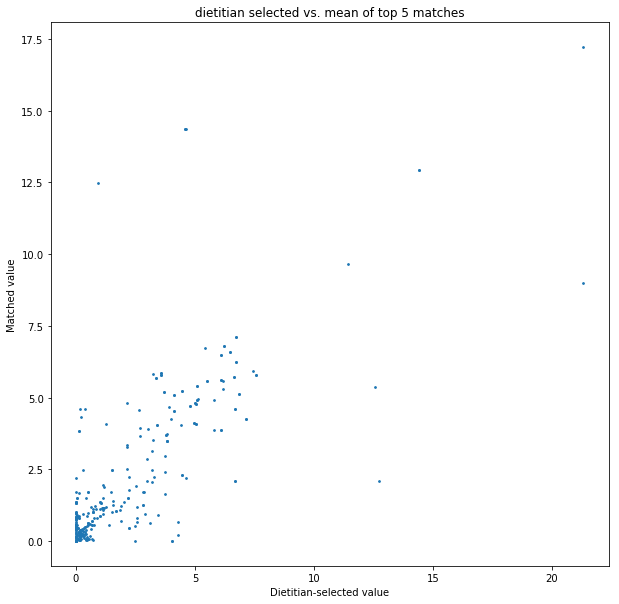

In [406]:
# plot_results(labeled_lactose_first,lookup_lactose_mean_top,'dietitian selected vs. mean of top 5 matches')